<a href="https://colab.research.google.com/github/nanac0n/2024ML_Are_U_T/blob/main/Project_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import random
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# nltk 데이터 다운로드
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# 데이터 로드 및 전처리
file_path = '/content/drive/MyDrive/adasyn.csv'
df = pd.read_csv(file_path)

df['type'] = df['type'].replace({
    'INTJ': 'T', 'INTP': 'T', 'ENTJ': 'T', 'ENTP': 'T',
    'ISTJ': 'T', 'ISTP': 'T', 'ESTJ': 'T', 'ESTP': 'T',
    'INFJ': 'F', 'INFP': 'F', 'ENFJ': 'F', 'ENFP': 'F',
    'ISFJ': 'F', 'ISFP': 'F', 'ESFJ': 'F', 'ESFP': 'F'
})

texts = df['posts'].values
labels = df['type'].values

# 텍스트 토큰화 및 패딩
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxlen = 100
data = pad_sequences(sequences, maxlen=maxlen)

# 라벨 인코딩 (T -> 0, F -> 1)
label_dict = {'T': 0, 'F': 1}
labels = np.array([label_dict[label] for label in labels])

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 데이터 증강 함수
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def synonym_replacement(text, n):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)
    return sentence




<ipython-input-3-718ecfd2b2b2>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 배치로 텍스트 데이터 증강
def augment_data(texts, n_aug=2, n_replace=1):
    augmented_texts = []
    for text in texts:
        for _ in range(n_aug):
            augmented_text = synonym_replacement(text, n_replace)
            augmented_texts.append(augmented_text)
    return np.array(augmented_texts)

batch_size = 1000  # 배치 크기 설정
augmented_texts = []
augmented_labels = []

for start in range(0, len(texts), batch_size):
    end = min(start + batch_size, len(texts))
    batch_texts = texts[start:end]
    batch_labels = labels[start:end]
    batch_augmented_texts = augment_data(batch_texts)
    augmented_texts.extend(batch_texts)
    augmented_texts.extend(batch_augmented_texts)
    augmented_labels.extend(batch_labels)
    augmented_labels.extend(batch_labels.repeat(len(batch_augmented_texts) // len(batch_texts)))

texts = np.array(augmented_texts)
labels = np.array(augmented_labels)

# 텍스트 토큰화 및 패딩 갱신
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=maxlen)

# 학습 및 테스트 데이터 분리 갱신
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 하이퍼파라미터 튜닝을 위한 모델 빌더 함수
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=64, max_value=128, step=32), input_length=maxlen))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=64, step=32), return_sequences=True, dropout=hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1))))
    model.add(Bidirectional(LSTM(hp.Int('lstm_units', min_value=32, max_value=64, step=32), dropout=hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1))))
    model.add(BatchNormalization())
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=64, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Keras Tuner를 사용한 하이퍼파라미터 튜닝
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=3,  # 시도 횟수를 줄여 메모리 사용량 감소
                     executions_per_trial=1,
                     directory='my_dir',
                     project_name='lstm_tuning')

# 튜닝 수행
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])  # 배치 크기 줄이기

# 최적의 하이퍼파라미터로 모델 학습
best_model = tuner.get_best_models(num_models=1)[0]

# 모델 평가
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Trial 3 Complete [00h 15m 25s]
val_accuracy: 0.9154937267303467

Best val_accuracy So Far: 0.9154937267303467
Total elapsed time: 00h 45m 21s
2931/2931 [==============================] - 23s 7ms/step - loss: 0.2345 - accuracy: 0.9143
Test Accuracy: 0.9143


In [20]:
best_model.save("/content/drive/MyDrive/lstm_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import joblib

# 모델 저장
model_save_path = '/content/drive/MyDrive/lstm_model.pkl'  # 드라이브 내 저장 경로 설정
joblib.dump(best_model, model_save_path)

['/content/drive/MyDrive/lstm_model.pkl']

In [ ]:
import matplotlib.pyplot as plt

2931/2931 [==============================] - 21s 7ms/step - loss: 0.2345 - accuracy: 0.9143
Test Accuracy: 0.9143
2931/2931 [==============================] - 19s 6ms/step
ROC AUC Score: 0.9690
F1 Score: 0.0000
              precision    recall  f1-score   support

           0       0.47      1.00      0.64     43914
           1       0.00      0.00      0.00     49866

    accuracy                           0.47     93780
   macro avg       0.23      0.50      0.32     93780
weighted avg       0.22      0.47      0.30     93780

Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


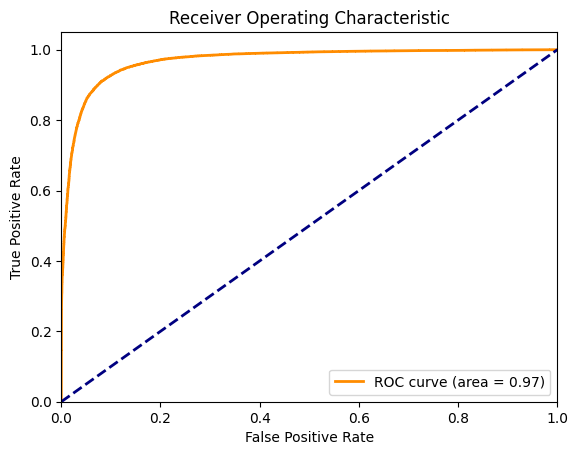

In [17]:
# 모델 평가
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# ROC AUC Score, F1 Score 및 Confusion Matrix 계산
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc, classification_report

# 예측 수행
predictions = best_model.predict(X_test)
preds = np.argmax(predictions, axis=1)  # 멀티클래스 분류를 위한 axis 설정

# 정확도 및 기타 성능 지표 계산
roc_auc = roc_auc_score(y_test, predictions)  # 이진 분류 가정; Softmax 확률 중 '1' 클래스의 확률을 사용
f1 = f1_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

# 성능 지표 출력
print(f'ROC AUC Score: {roc_auc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(classification_report(y_test, preds))

# 특이도 계산
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f'Specificity: {specificity:.4f}')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predictions.ravel())  # Extract probabilities from the single column
roc_auc = auc(fpr, tpr)

# ROC Curve 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
